In [2]:
import jax.numpy as np
import jax.ops
from jax import grad, jit, vmap
from functools import partial


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

In [7]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'][:1000])
y = np.array(data['D'][:1000])

In [4]:
def fill_diagonal(a, value):
    return jax.ops.index_update(a, np.diag_indices(a.shape[0]), value)

@jit
def descriptor(x):
    distances = np.sum((x[:, None] - x[None, :])**2, axis=-1)
    distances = fill_diagonal(distances, 1) # because sqrt fails to compute gradient if called on 0s
    distances = np.sqrt(distances)
    D = 1 / distances
    D = np.tril(D)
    D = fill_diagonal(D, 0)
    return D.flatten()

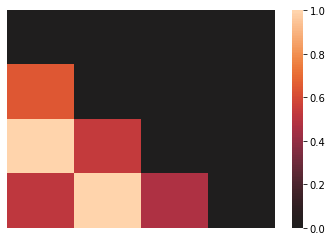

In [14]:
kwargs = {'center': 0, 'vmax': 1.0, 'xticklabels': False, 'yticklabels': False }

def animate(i):
    plt.clf()
    data = descriptor(X[i]).reshape(4, 4)
    sns.heatmap(data, **kwargs)

anim = animation.FuncAnimation(plt.figure(), animate, frames=20, repeat=False)
anim.save('supz2.gif')

In [ ]:
def heatmap_animation(generator, name='what', **heatmap_kwargs):
    kwargs = {'xticklabels': False, 'yticklabels': False, **heatmap_kwargs}

    def animate(i):
        plt.clf()
        data = generator(i)
        sns.heatmap(data, **kwargs)

    anim = animation.FuncAnimation(plt.figure(), animate, frames=20, repeat=False)
    anim.save(f'{name}.gif')

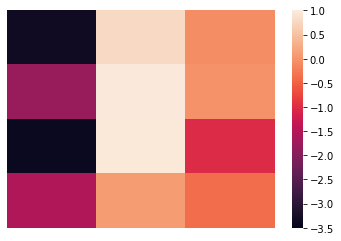

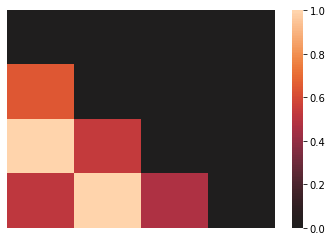

In [21]:
heatmap_animation(lambda i: X[i], name='coordinates', vmin=-3.5, vmax=1)
heatmap_animation(lambda i: descriptor(X[i]).reshape(4, 4), name='descriptors', center=0, vmax=1.0)

The following are the coordinates
![SegmentLocal](coordinates.gif "coordinates")
and descriptors
![SegmentLocal](descriptors.gif "descriptors")
for the first few training samples

In [4]:
@jit
def gaussian(x, x_, sigma=1):
    d, d_ = descriptor(x), descriptor(x_)
    sq_distance = np.sum((d - d_)**2)
    return np.exp(-sq_distance / sigma)
    

In [5]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

In [6]:
from jax.config import config
config.update("jax_debug_nans", True)

In [7]:
_gaussian = partial(gaussian, X[0])
hess = hessian(_gaussian)
hess(X[1]).shape

(4, 3, 4, 3)

In [79]:
def hess_ij(H):
    return np.sum(H, axis=(0, 2))
    K = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            value = np.sum(H[:, i, :, j])
            K = jax.ops.index_update(K, jax.ops.index[i, j], value)
    return K

In [78]:
H = hess(X[1])
%timeit np.sum(H, axis=(0, 2))
%timeit hess_ij(H)

190 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
37.2 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
@jit
def kernel(x, x_):
    _gaussian = partial(gaussian, x)
    hess = hessian(_gaussian)
    return hess_ij(hess(x_))

In [81]:
def kernel_matrix(X):
    samples = X.shape[0]
    # K = np.zeros((samples, samples, 3, 3))
    K = list()
    for i in range(samples):
        K.append(list())
        for j in range(samples):
            # K = jax.ops.index_update(K, jax.ops.index[i, j], kernel(X[i], X[j]))
            K[i].append(kernel(X[i], X[j]))
    K = np.block(K)
    return K

In [58]:
K = kernel_matrix(X[:10])

In [59]:
K.shape

(30, 30)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def matrix_heatmap(matrix, plt=plt, **kwargs):
    ax = sns.heatmap(K, xticklabels=False, yticklabels=False, **kwargs)
    plt.show()

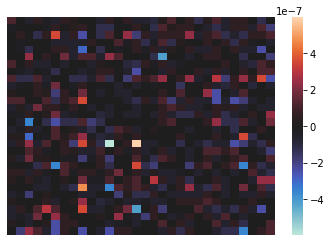

In [87]:
matrix_heatmap(K, center=0)

In [65]:
K = fill_diagonal(K, K.diagonal() + 1e-15)
samples = 10
y_ = y[:10].reshape(samples * 3)
alphas = np.linalg.solve(K, y_)
alphas = alphas.reshape(10, 3)

In [66]:
def predict(x, samples=samples, X=X, alphas=alphas):
    mu = np.zeros(3)
    for i in range(samples):
        mu += kernel(x, X[i]) @ alphas[i]
    return mu

In [69]:
y = y[:10].reshape(10, 3)
print(predict(X[9]))
print(y[9])

[ 0.0460642  -0.28939608 -0.5582838 ]
[ 0.04606372 -0.28939605 -0.5582838 ]


In [82]:
from utils import KRR

class VectorValuedKRR(KRR):

    def fit(self, X, y):
        self.X = X
        samples = X.shape[0]
        K = kernel_matrix(X)
        y = y.reshape(samples * 3)
        K = fill_diagonal(K, K.diagonal() + self.lamb)
        alphas = np.linalg.solve(K, y)
        self.alphas = alphas.reshape(samples, 3)

    def predict(self, x):
        results = [predict(_x, samples=self.samples, X=self.X, alphas=self.alphas) for _x in x]
        return np.array(results)

    def score(self, x, y):
        yhat = self.predict(x)
        return -np.mean(np.sum(np.abs(y - yhat), axis=1))


In [83]:
model = VectorValuedKRR()
model.fit(X[:10], y[:10])

In [84]:
print(model.predict([X[51]]))
print(y[51])

[[-0.09556997 -1.0142157   0.7243877 ]]
[-0.02243282  0.16857044  0.3250411 ]


In [85]:
model.score(X[:10], y[:10])

DeviceArray(-9.4734133e-07, dtype=float32)